In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
df =  pd.read_csv('/Users/eliewahachaligha/Desktop/ML-Zoomcamp/course_homework/ml-zoomcamp-homework-2025/03-Classification/data-week-3.csv')

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)
df.churn = (df.churn == 'yes').astype(int)



In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop= True)
df_val = df_val.reset_index(drop= True)
df_test = df_test.reset_index(drop= True)

y_train = df_train.churn.values
y_val   =  df_val.churn.values
y_test  = df_test.churn.values

del df_train['churn']
del df_test['churn']
del df_val['churn']



In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
 
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

DictVectorizer instance. We then transform the dataframe into dictionaries, and using the ‘fit_transform(train_dict)’ function, we train the DictVectorizer. This step involves showing the DictVectorizer how the data is structured, allowing it to distinguish column names and values and perform one-hot encoding based on this information. Importantly, the DictVectorizer is smart enough to distinguish between categorical values and numeric values, so numeric values are ignored during one-hot encoding. The ‘transform’ part of this process converts the dictionary into a vector or matrix suitable for machine learning.



In [6]:
dv = DictVectorizer(sparse=False)
 
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
 
model = LogisticRegression()
model.fit(X_train, y_train)

/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


We can then proceed to validate the trained model using the validation data. To do this, we need to prepare the validation DataFrame in the same way as shown for the training DataFrame. This involves transforming it into dictionaries and applying the ‘transform’ function of the DictVectorizer. However, during validation, we only need to use the ‘transform’ function of the DictVectorizer since it already knows the data structure. In the case of validation, we are primarily interested in the transformed output, which serves as input for prediction.

For prediction, we use the ‘predict_proba’ function of the model, which provides us with probabilities in two columns. Here, we are interested in the second column. We evaluate the model’s performance using a threshold of ‘>=0.5’. The ‘churn_decision’ variable contains ‘True’ for any value in the prediction greater than or equal to the threshold, and ‘False’ otherwise. We calculate the accuracy using the ‘mean’ function, and in this case, it is approximately 80%.

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient= 'records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

1. Accuracy and Dummy Model
    1. Evaluate the model on different thresholds
    2. Check Accuracy of Dummy Baseline


## Accuracy and Dummy Model
In the last article, we calculated that our model achieved an accuracy of 80% on the validation data. Now, let’s determine whether this is a good value or not.

Accuracy measures the fraction of correct predictions made by the model.

In our evaluation, we checked each customer in the validation dataset to determine whether the model’s churn prediction was correct or incorrect. This decision was based on our threshold of 0.5, meaning a customer with a predicted value greater than or equal to 0.5 was considered a churning customer, while values below the threshold were considered non-churning customers.

Out of the 1409 customers in the validation dataset, we made 1132 correct predictions. Therefore, the accuracy is calculated as 1132/1409 = 0.80, which corresponds to 80%. This accuracy indicates that our model correctly predicted the churn status for 80% of the customers in the validation dataset. Whether this is considered good or not depends on the specific context and requirements of the problem.

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).sum()

np.int64(1132)

In [10]:
1132/1409

0.8034066713981547

In [11]:
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

## Evaluate the model on different thresholds
The question now is whether we have chosen a good value for the threshold. To evaluate this, we can adjust the threshold and perform validation again. By systematically varying the threshold, we can observe whether it improves the accuracy or not. To do this, we can use the ‘linspace’ function from NumPy to generate an array with multiple threshold values (e.g., 21 values evenly spaced between 0 and 1). For each threshold value, we can calculate the accuracy and then determine the best threshold value based on the validation results. This process allows us to fine-tune the threshold to optimize the model’s performance.



In [12]:
thresholds = np.linspace(0,1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [13]:
scores= []
for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f'%(t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.773
0.40 0.785
0.45 0.794
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


It appears that 0.5 is indeed the best threshold based on the validation set. This suggests that the default threshold of 0.5 is an appropriate choice for our model in this context. To visually represent this threshold optimization process, we can create a plot. The x-axis will represent the threshold values, while the y-axis will represent the corresponding scores (in this case, accuracy or another relevant metric). This plot will provide a clear visualization of how the model’s performance varies with different threshold values, helping us identify the threshold that maximizes the desired metric.

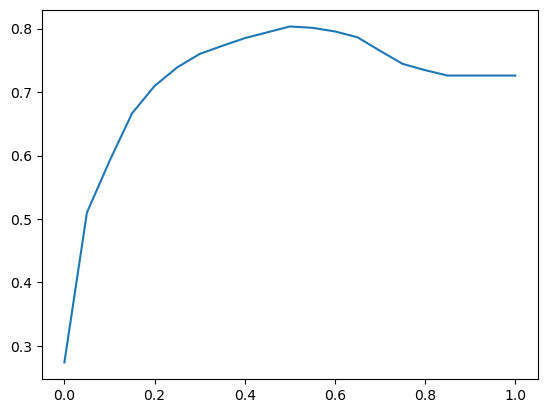

In [14]:
plt.plot(thresholds,scores)

While we used our custom function to calculate accuracy, it’s worth noting that Scikit-Learn provides built-in functions for common evaluation metrics, including accuracy. These built-in functions can simplify the process of evaluating your model’s performance, making it more convenient and efficient.

In [15]:
from sklearn.metrics import accuracy_score

threasholds = np.linspace(0,1, 21)
scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f'%(t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.773
0.40 0.785
0.45 0.794
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


## Check Accuracy of Dummy Baseline
There is an important point about the limitations of accuracy as an evaluation metric. While we may achieve a certain level of accuracy, it doesn’t always provide the full picture of a model’s performance, especially in cases with imbalanced datasets or when specific types of errors are more critical than others.

In this example, I’ve mentioned that the accuracy of the model is 80%, but a dummy model that predicts all customers as not churning achieves an accuracy of 73%. This highlights the issue with accuracy, as it doesn’t differentiate between different types of errors. In churn prediction, false negatives (predicting a customer won’t churn when they actually do) can be more costly than false positives (predicting a customer will churn when they won’t).

Choosing the most appropriate evaluation metric depends on the specific goals and requirements of the problem. For example, in cases where minimizing false negatives is crucial (e.g., in medical diagnoses or fraud detection), recall may be a more relevant metric than accuracy.

In [16]:
from collections import Counter

Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [17]:
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

In [18]:
1023/1409

0.7260468417317246

In [19]:
y_val.mean()

np.float64(0.2739531582682754)

In [20]:
1 - y_val.mean()

np.float64(0.7260468417317246)

We can observe that there are significantly more non-churning customers than churning ones, with only 27% being churning customers and 73% being non-churning customers. This situation highlights a common challenge known as class imbalance, where one class has far more samples than the other.

In cases of class imbalance, the traditional accuracy metric can be misleading. For example, a dummy model that predicts the majority class for all samples can achieve a high accuracy simply by getting most of the samples right for the majority class. However, it will perform poorly in identifying the minority class (in this case, the churning customers), which is often more crucial to predict accurately.

To effectively address class imbalance and evaluate our model, we should consider alternative metrics such as:

 1. Precision: This metric measures the proportion of true positive predictions among all positive predictions. It is particularly useful when the cost of false positives is high.
 2. Recall: Recall measures the proportion of true positive predictions among all actual positive instances. It is valuable when the cost of false negatives is significant.
 3. F1-Score: The F1-Score is the harmonic mean of precision and recall, providing a balanced measure that considers both false positives and false negatives.
 4. Area Under the Receiver Operating Characteristic Curve (AUC-ROC): The ROC curve plots the true positive rate against the false positive rate at various threshold settings. The AUC-ROC score assesses the classifier’s ability to distinguish between the positive and negative classes, making it particularly useful for imbalanced datasets.


Selecting the appropriate evaluation metric depends on the specific goals and requirements of the problem. In cases of class imbalance, accurate identification of the minority class (churning customers) is crucial.

1. Confusion table / matrix
   * Different types of errors and correct decisions
   * Arranging them in a table

### Confusion table / matrix

### Different types of errors and correct decisions
In this section, we’ll discuss the confusion matrix, a vital tool for evaluating the performance of binary classification models. The confusion matrix allows us to examine the various errors and correct decisions made by our model.

As we’ve previously discussed, class imbalance can significantly impact the accuracy metric. To address this issue, we need alternative evaluation methods that provide a more comprehensive view of our model’s performance.

The confusion matrix breaks down the model’s predictions into four categories:

 1. True Positives (TP): These are cases where the model correctly predicted the positive class (churning customers).
 2. True Negatives (TN): These are cases where the model correctly predicted the negative class (non-churning customers).
 3. False Positives (FP): These are cases where the model incorrectly predicted the positive class when the true class was negative. This is also known as a Type I error.
 4. False Negatives (FN): These are cases where the model incorrectly predicted the negative class when the true class was positive. This is also known as a Type II error.

In [27]:
#people who are going to churn
actual_positive = (y_val == 1)

In [31]:
#people who are not going to churn

actual_negative = (y_val == 0)

In [32]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

We examine the cases where both “predict_positive” and “actual_positive” are true. This is precisely what the “&” operator represents, indicating a logical AND operation.

In [30]:
We examine the cases where both “predict_positive” and “actual_positive” are true. This is precisely what the “&” operator represents, indicating a logical AND operation.

SyntaxError: invalid character '“' (U+201C) (2004203919.py, line 1)

In [33]:
predict_positive & actual_positive

array([False, False, False, ..., False,  True,  True])

In [34]:
tp = (predict_positive & actual_positive).sum()
tp

np.int64(210)

In [35]:
tn = (predict_negative & actual_negative).sum()
tn

np.int64(922)

In [36]:
fp = (predict_positive & actual_negative).sum()
fp

np.int64(101)

In [37]:
fn = (predict_negative & actual_positive).sum()
fn

np.int64(176)

## Arranging them in table

That was preparation for understanding the confusion matrix. The confusion matrix is a way to consolidate all these values (tp, tn, fp, fn) into a single table. This table comprises 4 cells, forming a 2×2 matrix.

In the columns of this table, we have the predictions (NEGATIVE: g(xi) < t and POSITIVE: g(xi) >= t).
In the rows, we have the actual values (NEGATIVE: y=0 and POSITIVE: y=1).


Now, let’s proceed to implement this confusion matrix in NumPy.

In [38]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[922, 101],
       [176, 210]])

## Confusion Matrix & Accuracy

### Prediction vs Actual (Churn Model)

| **Actual / Prediction** | **NO CHURN**<br>g(xᵢ) < t<br>(NEGATIVE) | **CHURN**<br>g(xᵢ) ≥ t<br>(POSITIVE) |
|-------------------------|-------------------------------------------|---------------------------------------|
| **NO CHURN (y = 0)**    | **True Negative (TN)**<br>922 (65%)       | **False Positive (FP)**<br>101 (8%)   |
| **CHURN (y = 1)**       | **False Negative (FN)**<br>176 (12%)      | **True Positive (TP)**<br>210 (15%)   |

### Notes
- **x-axis:** Predictions  
- **y-axis:** Actual values  
- **Accuracy:** 65% + 15% = **80%**


We observe that we have more false negatives than false positives. False positives represent customers who receive the email even though they are not likely to churn, resulting in a loss of money due to unnecessary discounts. False negatives are customers who do not receive the email and end up leaving, causing financial losses as well. Both situations are undesirable.

Instead of using absolute numbers, we can also express these values in relative terms to gain a better perspective on the model’s performance.

In [39]:
(confusion_matrix/confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## Precision & Recall
Precision and Recall are essential metrics for evaluating binary classification models.

Precision measures the fraction of positive predictions that were correct. In other words, it quantifies how accurately the model predicts customers who are likely to churn.

Precision = True Positives / (# Positive Predictions) = True Positives / (True Positives + False Positives)

Recall, on the other hand, quantifies the fraction of actual positive cases that were correctly identified by the model. It assesses how effectively the model captures all customers who are actually churning.

Recall = True Positives / (# Positive Observations) = True Positives / (True Positives + False Negatives)

In summary, precision focuses on the accuracy of positive predictions, while recall emphasizes the model’s ability to capture all positive cases. These metrics are crucial for understanding the trade-offs between correctly identifying churning customers and minimizing false positives.

## Confusion Matrix Structure

| **Actual Values** | **Negative Predictions**<br>g(xᵢ) < t | **Positive Predictions**<br>g(xᵢ) ≥ t |
|-------------------|----------------------------------------|----------------------------------------|
| **Negative Example (y = 0)**   | **TN** | **FP** |
| **Positive Example (y = 1)**   | **FN** | **TP** |

### Formulas
Confusion matrix Recall=TP/(TP+FN) Precision=TP/(TP+FP)

In [40]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy

np.float64(0.8034066713981547)

In [41]:
precision = tp / (tp + fp)
precision

np.float64(0.6752411575562701)

In [42]:
# --> promotional email goes to 311 people, but 210 are actually going to churn (--> 33% are mistakes)

tp + fp

np.int64(311)

In [43]:
recall = tp/ (tp + fn)
recall

np.float64(0.5440414507772021)

In [44]:
tp + fn

np.int64(386)

While accuracy can give a misleading impression of a model’s performance, metrics like precision and recall are much more informative, especially in situations with class imbalance. Precision and recall provide a more detailed understanding of how well the model is performing in identifying positive cases (in this case, churning customers).

In scenarios where correctly identifying specific cases is critical, such as identifying churning customers to prevent loss, precision and recall help us make more informed decisions and assess the trade-offs between correctly identifying positives and minimizing false positives or false negatives. So, relying solely on accuracy may not provide a complete picture of a model’s effectiveness for a particular task.

1. ROC Curve (Receiver Operating Characteristics)
 * Random model
 * Ideal model
 * Putting everything together
 * What kind of information do we get from ROC curve?

## ROC Curve (Receiver Operating Characteristic)

ROC(Receiver Operating Characteristic) curves are a valuable tool for evaluating binary classification models, especially in scenarios where you want to assess the trade-off between false positives and true positives at different decision thresholds.

The ROC curve visually represents the performance of a model by plotting the TPR (True Positive Rate or Sensitivity) against the FPR (False Positive Rate or 1 – Specificity) at various threshold settings. The area under the ROC curve (AUC-ROC) is a summary measure of a model’s overall performance, with a higher AUC indicating better discrimination between positive and negative cases.

ROC curves help you make informed decisions about the choice of threshold that balances your priorities between minimizing false positives (FPR) and maximizing true positives (TPR) based on the specific context and requirements of your problem.


| **Actual Values**           | **Negative Predictions**<br>g(xᵢ) < t | **Positive Predictions**<br>g(xᵢ) ≥ t | **Rate** |
|-----------------------------|----------------------------------------|----------------------------------------|-----------|
| **Negative Example (y = 0)** | **TN**                                 | **FP**                                 | **FPR = FP / (TN + FP)** |
| **Positive Example (y = 1)** | **FN**                                 | **TP**                                 | **TPR = TP / (FN + TP)** |




confusion matrix FPR - False Posite Rate TPR - True Positive Rate

In [45]:
tpr = tp/ (tp + fn)
tpr

np.float64(0.5440414507772021)

In [46]:
fpr = fp / (fp + tn)
fpr

np.float64(0.09872922776148582)

The ROC curve is a useful visualization tool that allows you to assess the performance of a binary classification model across a range of decision thresholds.

In [47]:
scores = []
thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
 
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
 
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
 
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
 
    scores.append((t, tp, tn, fp, fn))
 
scores

[(np.float64(0.0), np.int64(386), np.int64(0), np.int64(1023), np.int64(0)),
 (np.float64(0.01), np.int64(385), np.int64(109), np.int64(914), np.int64(1)),
 (np.float64(0.02), np.int64(384), np.int64(193), np.int64(830), np.int64(2)),
 (np.float64(0.03), np.int64(383), np.int64(257), np.int64(766), np.int64(3)),
 (np.float64(0.04), np.int64(381), np.int64(308), np.int64(715), np.int64(5)),
 (np.float64(0.05), np.int64(379), np.int64(340), np.int64(683), np.int64(7)),
 (np.float64(0.06), np.int64(377), np.int64(362), np.int64(661), np.int64(9)),
 (np.float64(0.07), np.int64(372), np.int64(383), np.int64(640), np.int64(14)),
 (np.float64(0.08), np.int64(371), np.int64(410), np.int64(613), np.int64(15)),
 (np.float64(0.09), np.int64(369), np.int64(443), np.int64(580), np.int64(17)),
 (np.float64(0.1), np.int64(366), np.int64(467), np.int64(556), np.int64(20)),
 (np.float64(0.11), np.int64(365), np.int64(495), np.int64(528), np.int64(21)),
 (np.float64(0.12), np.int64(365), np.int64(514), 

We end up with 101 confusion matrices evaluated for different thresholds. Let’s turn that into a dataframe.

In [48]:
columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,tp,tn,fp,fn
0,0.00,386,0,1023,0
1,0.01,385,109,914,1
2,0.02,384,193,830,2
3,0.03,383,257,766,3
4,0.04,381,308,715,5
...,...,...,...,...,...
96,0.96,0,1023,0,386
97,0.97,0,1023,0,386
98,0.98,0,1023,0,386
99,0.99,0,1023,0,386


We can look at each tenth record by using this column 10 operator. This works by printing every record starting from the first record and moving forward with increments of 10.

In [49]:
df_scores[::10]

,threshold,tp,tn,fp,fn
0,0.0,386,0,1023,0
10,0.1,366,467,556,20
20,0.2,333,667,356,53
30,0.3,284,787,236,102
40,0.4,249,857,166,137
50,0.5,210,922,101,176
60,0.6,151,970,53,235
70,0.7,75,1003,20,311
80,0.8,13,1022,1,373
90,0.9,0,1023,0,386


In [50]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,366,467,556,20,0.948187,0.543500
20,0.2,333,667,356,53,0.862694,0.347996
30,0.3,284,787,236,102,0.735751,0.230694
40,0.4,249,857,166,137,0.645078,0.162268
50,0.5,210,922,101,176,0.544041,0.098729
60,0.6,151,970,53,235,0.391192,0.051808
70,0.7,75,1003,20,311,0.194301,0.019550
80,0.8,13,1022,1,373,0.033679,0.000978
90,0.9,0,1023,0,386,0.000000,0.000000


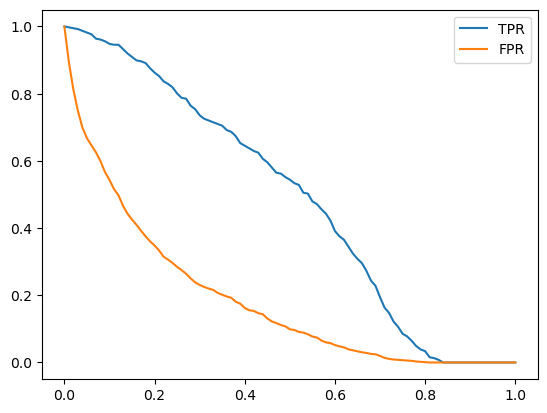

In [51]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

## Random model

In [52]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [53]:
# Accuracy for our random model is around 50% 
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

Let’s put the previously used code into a function.

In [54]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
 
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
 
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
 
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
 
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
 
        scores.append((t, tp, tn, fp, fn))
 
    columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
    df_scores = pd.DataFrame(scores, columns=columns)
 
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
 
    return df_scores

In [56]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,347,100,923,39,0.898964,0.902248
20,0.2,307,201,822,79,0.795337,0.803519
30,0.3,276,299,724,110,0.715026,0.707722
40,0.4,237,399,624,149,0.613990,0.609971
50,0.5,202,505,518,184,0.523316,0.506354
60,0.6,161,614,409,225,0.417098,0.399804
70,0.7,121,721,302,265,0.313472,0.295210
80,0.8,78,817,206,308,0.202073,0.201369
90,0.9,40,922,101,346,0.103627,0.098729


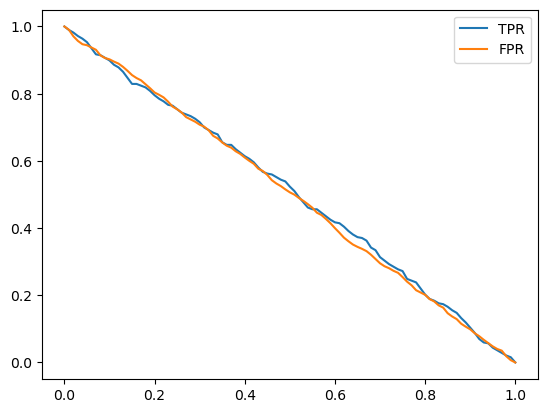

In [57]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

Let’s examine an example using a threshold of 0.6. On the x-axis, we have our thresholds, and when we set the threshold to 0.6, we obtain a True Positive Rate (TPR) of 0.4 and a False Positive Rate (FPR) of 0.4.

The reason behind these values is that our model’s predictions are nearly equivalent to tossing a coin. In 60% of cases, the model predicts that a customer is non-churning, and in 40% of cases, it predicts that the customer is churning. In other words, these rates indicate that the model predicts a customer as churning with a 40% probability and as non-churning with a 60% probability. Consequently, the model is incorrect for non-churning customers in 40% of cases.

## Ideal model
Now, let’s discuss the concept of an ideal model that makes correct predictions for every example. To implement this, we need to determine the number of negative examples, which corresponds to the number of people who are not churning in our dataset.

In [58]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

To create the ideal model’s predictions for our validation set, we first create a y_ideal array that contains only negative observations (0s) followed by positive observations (1s). We use the np.repeat() function to achieve this, creating an array with 1023 zeros and then 386 ones.

In [59]:
y_ideal= np.repeat([0,1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

To create our predictions for the ideal model, which are numbers between 0 and 1, we can use the np.linspace() function to generate an array of evenly spaced values between 0 and 1. This array should have the same length as y_ideal, which is 1409 in this case.

In [60]:
y_ideal_pred = np.linspace(0, 1, len(y_ideal))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [61]:
1 - y_val.mean()


np.float64(0.7260468417317246)

In [62]:
accuracy_ideal = ((y_ideal_pred >= 0.726) == y_ideal).mean()
accuracy_ideal

np.float64(1.0)

The ideal model, which makes perfect predictions, doesn’t exist in reality, but it serves as a benchmark to understand how well our actual model is performing. By comparing our model’s performance to that of the ideal model, we can assess how much room for improvement there is.

In [63]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,386,141,882,0,1.000000,0.862170
20,0.2,386,282,741,0,1.000000,0.724340
30,0.3,386,423,600,0,1.000000,0.586510
40,0.4,386,564,459,0,1.000000,0.448680
50,0.5,386,704,319,0,1.000000,0.311828
60,0.6,386,845,178,0,1.000000,0.173998
70,0.7,386,986,37,0,1.000000,0.036168
80,0.8,282,1023,0,104,0.730570,0.000000
90,0.9,141,1023,0,245,0.365285,0.000000


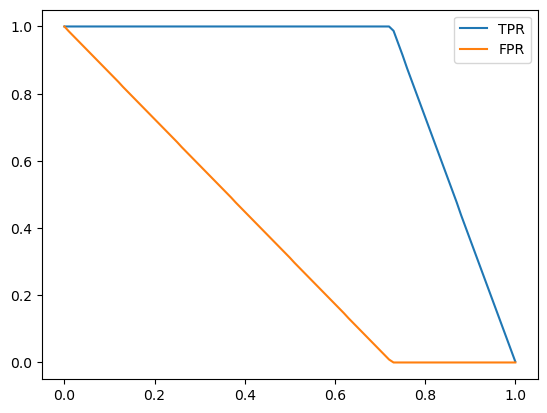

In [64]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

What we see here is that TPR almost always stays around 1 and starts to go down after the threshold of 0.726. So, this model can correctly identify churning customers up to that threshold. For people who are not churning but are classified as churning by the model when the threshold is below 0.726, the model is not always correct. However, the detection becomes always true after the threshold of 0.726.

Let’s take another example with a threshold of 0.4. The FPR is around 45%, and the model makes some mistakes. So, for around 32% of people who are predicted as non-churning when the threshold is set to 0.726 but are below that threshold, we predict them as churning even though they are not.

## Putting everything together
Now let’s try to plot all the models together so we can hold the benchmarks together.

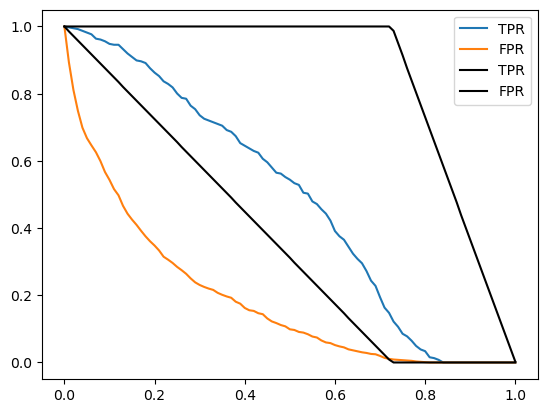

In [65]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
 
#plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
#plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
 
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR', color = 'black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR', color = 'black')
 
plt.legend()

We see that our TPR is far from the ideal model. We want it to be as close as possible to 1. We also notice that our FPR is significantly different from that of the ideal model. Plotting against the threshold is not always intuitive. For example, in our model, the best threshold is 0.5, as we know from accuracy. However, for the ideal model, as we saw earlier, the best threshold is 0.726. So they have different thresholds. What we can do to better visualize this is to plot FPR against TPR. On the x-axis, we’ll have FPR, and on the y-axis, we’ll have TPR. To make it easier to understand, we can also add the benchmark lines.

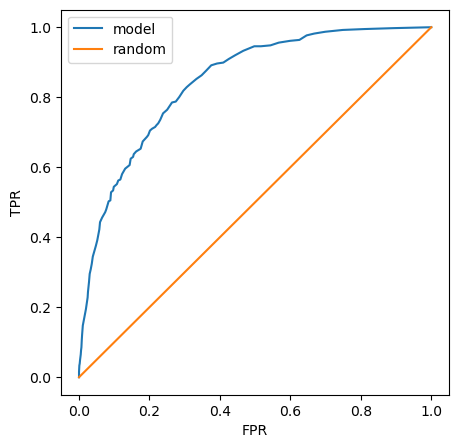

In [66]:
plt.figure(figsize=(5,5))
 
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label='random')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')
 
plt.xlabel('FPR')
plt.ylabel('TPR')
 
plt.legend()

In the curve of the ideal model, there is one crucial point, often referred to as the ‘north star’ or ideal spot, located in the upper-left corner where TPR is 100% and FPR is 0%. This point represents the optimal performance we aim to achieve with our model. A ROC curve visualizes this by plotting TPR against FPR, and we usually add a diagonal random baseline. Our goal is to make our model’s curve as close as possible to this ideal spot, which means simultaneously being as far away as possible from the random baseline. In essence, if our model closely resembles the random baseline model, it is not performing well.

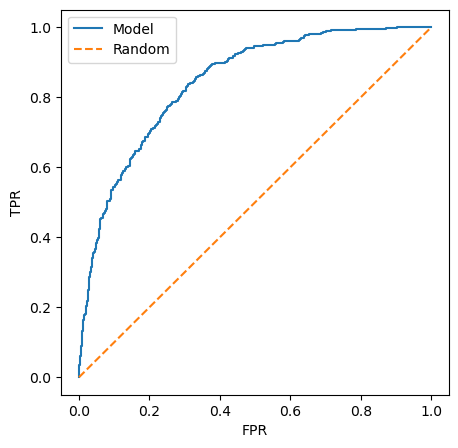

In [67]:
# We can also use the ROC functionality of scikit learn package
from sklearn.metrics import roc_curve
 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
 
plt.figure(figsize=(5,5))
 
plt.plot(fpr, tpr, label='Model')
plt.plot([0,1], [0,1], label='Random', linestyle='--')
 
plt.xlabel('FPR')
plt.ylabel('TPR')
 
plt.legend()

## What kind of information do we get from ROC curve?
Let’s begin in the lower-left corner, where both TPR and FPR are 0. This occurs at higher thresholds like 1.0. In this scenario, we predict that every customer is non-churning, resulting in TPR being 0 since we don’t predict anyone as churning. FPR is also 0 because there are no false positives; we only have true negatives (TN).

As we move from the lower left corner, where the threshold starts at 1.0, we eventually reach the upper-right corner with a threshold of 0.0. Here, our model achieves 100% TPR because we predict everyone as churning, enabling us to identify all churning customers. However, we also make many mistakes, incorrectly identifying non-churning customers. Thus, we have TPR = FPR = 100%.

When we adjust the threshold, we predict more customers as churning, causing our TPR to increase, but the FPR also increases concurrently.

The ROC curve allows us to observe how the model behaves at different thresholds. Each point on the ROC curve represents TPR and FPR evaluated at a specific threshold. By plotting this curve, we can assess how far the model is from the ideal spot and how far it is from the random baseline. Additionally, the ROC curve is useful for comparing different models, as it’s easy to determine which one is superior (a model closer to the ideal spot is better, while one closer to the random baseline is worse).

There is an interesting metric derived from the ROC curve known as AUC, which stands for the area under the curve.



1. ROC AUC – Area under the ROC curve
  * Useful metric
  * AUC interpretation

## ROC AUC – Area under the ROC curve
### Useful metric
One way to quantify how close we are to the ideal point is by measuring the area under the ROC curve (AUC). AUC equals 0.5 for a random baseline and 1.0 for an ideal curve. Therefore, our model’s AUC should fall between 0.5 and 1.0. When AUC is less than 0.5, we’ve made a mistake. AUC = 0.8 is considered good, while 0.9 is great, but 0.6 is considered poor. We can calculate AUC using the scikit-learn package. This package is not specifically for roc curves, this is for any curve. It can calculate area under any curve.

In [68]:
from sklearn.metrics import auc
# auc needs values for x-axis and y-axis
auc(fpr, tpr)

0.8438403760148704

In [69]:
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754536

In [70]:
auc(df_ideal.fpr, df_ideal.tpr)


0.9999430203759136

In [71]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438403760148704

There is a shortcut in scikit-learn package


In [72]:
from sklearn.metrics import roc_auc_score
 
roc_auc_score(y_val, y_pred)

0.8438403760148704

## AUC interpretation
AUC tells us the probability that a randomly selected positive example has a score that is higher than a randomly selected negative example.

In [73]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]


import random
pos_ind = random.randint(0, len(pos) -1)
neg_ind = random.randint(0, len(neg) -1)

We want to compare the score of this positive example with the score of the negative example.



In [76]:
pos[pos_ind] > neg[neg_ind]

np.False_

So, for this random example, this is true. We can do this 100,000 times and evaluate the performance.

In [77]:
n = 100000
success = 0
 
for i in range(n):
    pos_ind = random.randint(0, len(pos) -1)
    neg_ind = random.randint(0, len(neg) -1)
 
    if pos[pos_ind] > neg[neg_ind]:
        success += 1
 
success / n

0.84541

That result is quite close to roc_auc_score(y_val, y_pred) = 0.843850505725819.

Instead of implementing this manually, we can use NumPy. Be aware that in np.random.randint(low, high, size, dtype), ‘low’ is inclusive, and ‘high’ is exclusive.

In [78]:
n = 50000
 
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)
pos[pos_ind] > neg[neg_ind]
# Output: array([False,  True,  True, ...,  True,  True,  True])
 
(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.84654)

Because of this interpretation, AUC is quite popular as a way of measuring the performance of binary classification models. It’s quite intuitive, and we can use it to assess how well our model ranks positive and negative examples and separates positive examples from negative ones.

1. Cross-Validation
   * Evaluating the same model on different subsets of data
   * Getting the average prediction and the spread within predictions
   * Parameter Tuning

## Cross-Validation
### Evaluating the same model on different subsets of data

In this article, I’ll discuss parameter tuning, which involves selecting the optimal parameter. Typically, we start by splitting our entire dataset into three parts: training, validation, and testing. We utilize the validation dataset to determine the best parameter for the formula g(xi), essentially finding the optimal parameters for training our model.

For the time being, we set aside the test set and continue working with our combined training and validation dataset – so called full_train. Next, we divide this data into ‘k’ parts, with ‘k’ equal to 3.

FULL TRAIN

1 2 3
We can train our model using datasets 1 and 2, using dataset 3 for validation. Subsequently, we calculate the AUC on the validation dataset (3).

Next step is to train another model based on 1 and 3 and validate this model on dataset 2. Again compute the AUC on validation data (2).

TRAIN VAL

1 3 2

Next step is to train another model based on 2 and 3 and validate this model on dataset 1. Again compute the AUC on validation data (1).

TRAIN VAL

2 3 1

After obtaining three AUC values, we calculate their mean and standard deviation. The standard deviation reflects the model’s stability and how scores vary across different folds.

K-Fold Cross-Validation is a method for assessing the same model on various subsets of our dataset.

In [79]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression()
    model.fit(X_train, y_train)
 
    return dv, model

In [80]:
dv, model = train(df_train, y_train)

/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [81]:
def predict(df, dv, model):
     dicts = df[categorical + numerical].to_dict(orient='records')
 
     X = dv.fit_transform(dicts)
     y_pred = model.predict_proba(X)[:,1]
 
     return y_pred

In [82]:
y_pred = predict(df_val, dv, model)
y_pred

array([0.00901785, 0.20444184, 0.21211154, ..., 0.13644232, 0.79970308,
       0.837366  ])

We now have the ‘train’ and ‘predict’ functions in place. Let’s proceed to implement K-Fold Cross-Validation.

In [83]:
from sklearn.model_selection import KFold
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1) 
 
kfold.split(df_full_train)
# Output: <generator object _BaseKFold.split at 0x2838baf20>
 
train_idx, val_idx = next(kfold.split(df_full_train))
len(train_idx), len(val_idx)
# Output: (5070, 564)
 
len(df_full_train)
# Output: 5634
 
# We can use iloc to select a part of this dataframe
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

The following code snippet demonstrates the implementation for 10 folds. Finally, we use the ‘roc_auc_score’ function to calculate and output the corresponding score for each fold.

In [84]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
scores = []
 
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.churn.values
    y_val = df_val.churn.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
 
scores

/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    h

[0.8480988502456944,
 0.841042698019802,
 0.8557048652060528,
 0.8345732861492882,
 0.8266439205955335,
 0.8374292374292374,
 0.8445294692282643,
 0.8186195445920303,
 0.8453090262338817,
 0.8631306510705523]

Same implementation but this time with tqdm package.


In [85]:
from sklearn.model_selection import KFold
!pip3 install tqdm
from tqdm.auto import tqdm
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
scores = []
 
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.churn.values
    y_val = df_val.churn.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
 
scores

0it [00:00, ?it/s]

/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    h

[0.8480988502456944,
 0.841042698019802,
 0.8557048652060528,
 0.8345732861492882,
 0.8266439205955335,
 0.8374292374292374,
 0.8445294692282643,
 0.8186195445920303,
 0.8453090262338817,
 0.8631306510705523]

## Getting the average prediction and the spread within predictions

We can utilize the scores generated to compute the average score across the 10 folds, which is 84.1%, with a standard deviation of 0.012.

In [86]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.842 +- 0.012


## Parameter Tuning
We discussed parameter tuning, particularly the ‘C’ parameter in our LogisticRegression model, which serves as the regularization parameter with a default value of 1.0. We can include this ‘C’ parameter in our ‘train’ function. If ‘C’ is set to a very small value, it implies strong regularization. Additionally, we can address an annoying message by setting the ‘max_iter’ value to 1000.

In [87]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
 
    return dv, model


In [88]:
dv, model = train(df_train, y_train, C=0.001)

We can iterate over various values for ‘C,’ keeping in mind that ‘C’ cannot be set to 0.0, as it would result in an ‘InvalidParameterError.’ The ‘C’ parameter for LogisticRegression must be a float within the range (0.0, inf], so we need to avoid using 0.0.

In [89]:
from sklearn.model_selection import KFold
 
kfold = KFold(n_splits=10, shuffle=True, random_state=1)  
 
for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10]:
     
    scores = []
 
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
 
        y_train = df_train.churn.values
        y_val = df_val.churn.values
 
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
 
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
 
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.001 0.826 +- 0.012


/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

C=0.01 0.841 +- 0.012


/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

C=0.1 0.842 +- 0.012


/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

C=0.5 0.843 +- 0.012


/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

C=1 0.843 +- 0.012


/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

C=5 0.843 +- 0.012


/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

C=10 0.843 +- 0.012


/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We can implement the same procedure using the ‘tqdm’ package, which provides a more visually appealing output.

In [90]:
from sklearn.model_selection import KFold
 
n_splits = 5
 
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):   
    scores = []
 
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)  
 
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
 
        y_train = df_train.churn.values
        y_val = df_val.churn.values
 
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
 
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
 
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009


/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

C=0.01 0.840 +- 0.008


/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

C=0.1 0.842 +- 0.007


/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

C=0.5 0.842 +- 0.007


/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

C=1 0.842 +- 0.007


/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

C=5 0.842 +- 0.007


/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

C=10 0.842 +- 0.007


Afterward, we aim to train our final model using the entire training dataset (df_full_train) and then validate it using the test dataset.



In [91]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)
 
auc = roc_auc_score(y_test, y_pred)
auc

/Users/eliewahachaligha/anaconda3/envs/mlzoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8584952928813633

We observe that the AUC is slightly better than what we observed during k-fold cross-validation, though not significantly higher. This is expected when the difference is small.

In terms of when to use cross-validation versus traditional hold-out validation, for larger datasets, standard hold-out validation is often sufficient. However, if your dataset is smaller or you require insight into the model’s stability and variation across folds, then cross-validation is more appropriate. For larger datasets, consider using fewer splits (e.g., 2 or 3), while for smaller datasets, a higher number of splits (e.g., 10) may be beneficial.

**Deployment of this Model will be in another section**